# **Customer churn analysis and prediction**

**Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import RocCurveDisplay

**Loading data and basic dataset exploration**

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print('Dataset shape: ', df.shape)
print('Columns: ', df.columns.tolist())
print('Data types:\n', df.dtypes)

Dataset shape:  (7043, 21)
Columns:  ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Data types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [3]:
print('Sample rows:\n ', df.head())

Sample rows:
     customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies      

In [4]:
print('Missing values:\n', df.isnull().sum())

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [5]:
print('Unique values per column:')

for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Unique values per column:
customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


In [6]:
print("Churn distribution:", df['Churn'].value_counts())

print(f"\nChurn rate: {df['Churn'].value_counts(normalize=True)['Yes']:.2%}")

Churn distribution: Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn rate: 26.54%


**Data cleaning and missing value treatment for TotalCharges**

In [7]:
print("TotalCharges data type: ", df['TotalCharges'].dtype)

TotalCharges data type:  object


In [8]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

missing_tc = df['TotalCharges'].isna().sum()
print(f"Missing TotalCharges before fixing: ", {missing_tc})
df.loc[df['TotalCharges'].isna(), 'TotalCharges'] = (
    df.loc[df['TotalCharges'].isna(), 'MonthlyCharges'] * df.loc[df['TotalCharges'].isna(), 'tenure']
)
print(f"Missing TotalCharges after fixing: ", {df['TotalCharges'].isna().sum()})

print("TotalCharges data type: ", df['TotalCharges'].dtype)

Missing TotalCharges before fixing:  {np.int64(11)}
Missing TotalCharges after fixing:  {np.int64(0)}
TotalCharges data type:  float64


**Encoding binary categorical variables to numeric values**

In [9]:
binary_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
binary_mappings = {
    'gender': {'Female': 0, 'Male': 1},
    'Partner': {'No': 0, 'Yes': 1},
    'Dependents': {'No': 0, 'Yes': 1},
    'PhoneService': {'No': 0, 'Yes': 1},
    'PaperlessBilling': {'No': 0, 'Yes': 1},
    'Churn': {'No': 0, 'Yes': 1},
}

for col in binary_columns:
    df[col] = df[col].map(binary_mappings[col])
    print(f"{col} unique values after encoding: ", df[col].unique())

gender unique values after encoding:  [0 1]
Partner unique values after encoding:  [1 0]
Dependents unique values after encoding:  [0 1]
PhoneService unique values after encoding:  [0 1]
PaperlessBilling unique values after encoding:  [1 0]
Churn unique values after encoding:  [0 1]


**Replacing 'No internet service' and 'No phone service' values with 'No'**

In [10]:
internet_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_services:
    df[col] = df[col].replace('No internet service', 'No')
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')

**Feature engineering: creating new features for the model**

In [11]:
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,72], labels=['0-1 year','1-2 years','2-4 years','4+ years'])

df['avg_monthly_charges'] = df['TotalCharges'] / (df['tenure'] + 1)

In [12]:
df['high_monthly_charges'] = (df['MonthlyCharges'] > df['MonthlyCharges'].median()).astype(int)
df['high_total_charges'] = (df['TotalCharges'] > df['TotalCharges'].median()).astype(int)

In [13]:
for col in internet_services:
    df[col+'_binary'] = (df[col] == 'Yes').astype(int)

In [49]:
df['total_services'] = df['PhoneService'] + df[[col+'_binary' for col in internet_services]].sum(axis=1)

In [15]:
df['is_monthly_contract'] = (df['Contract'] == 'Month-to-month').astype(int)
df['automatic_payment'] = df['PaymentMethod'].str.contains('automatic', case=False).astype(int)

In [16]:
print("\nFeature engineering completed. Sample:")
print(df[['tenure_group', 'avg_monthly_charges', 'high_monthly_charges', 'high_total_charges', 'total_services', 'is_monthly_contract', 'automatic_payment']].head())



Feature engineering completed. Sample:
  tenure_group  avg_monthly_charges  high_monthly_charges  high_total_charges  \
0     0-1 year            14.925000                     0                   0   
1    2-4 years            53.985714                     0                   1   
2     0-1 year            36.050000                     0                   0   
3    2-4 years            40.016304                     0                   1   
4     0-1 year            50.550000                     1                   0   

   total_services  is_monthly_contract  automatic_payment  
0               1                    1                  0  
1               3                    0                  0  
2               3                    1                  0  
3               3                    0                  1  
4               1                    1                  0  


**Preparing dataset for Machine Learning: EDA on categorical and numeric columns**

In [17]:
categorical_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                   'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                   'Contract', 'PaymentMethod', 'tenure_group']

**Countplots for categorical variables, split by churn**

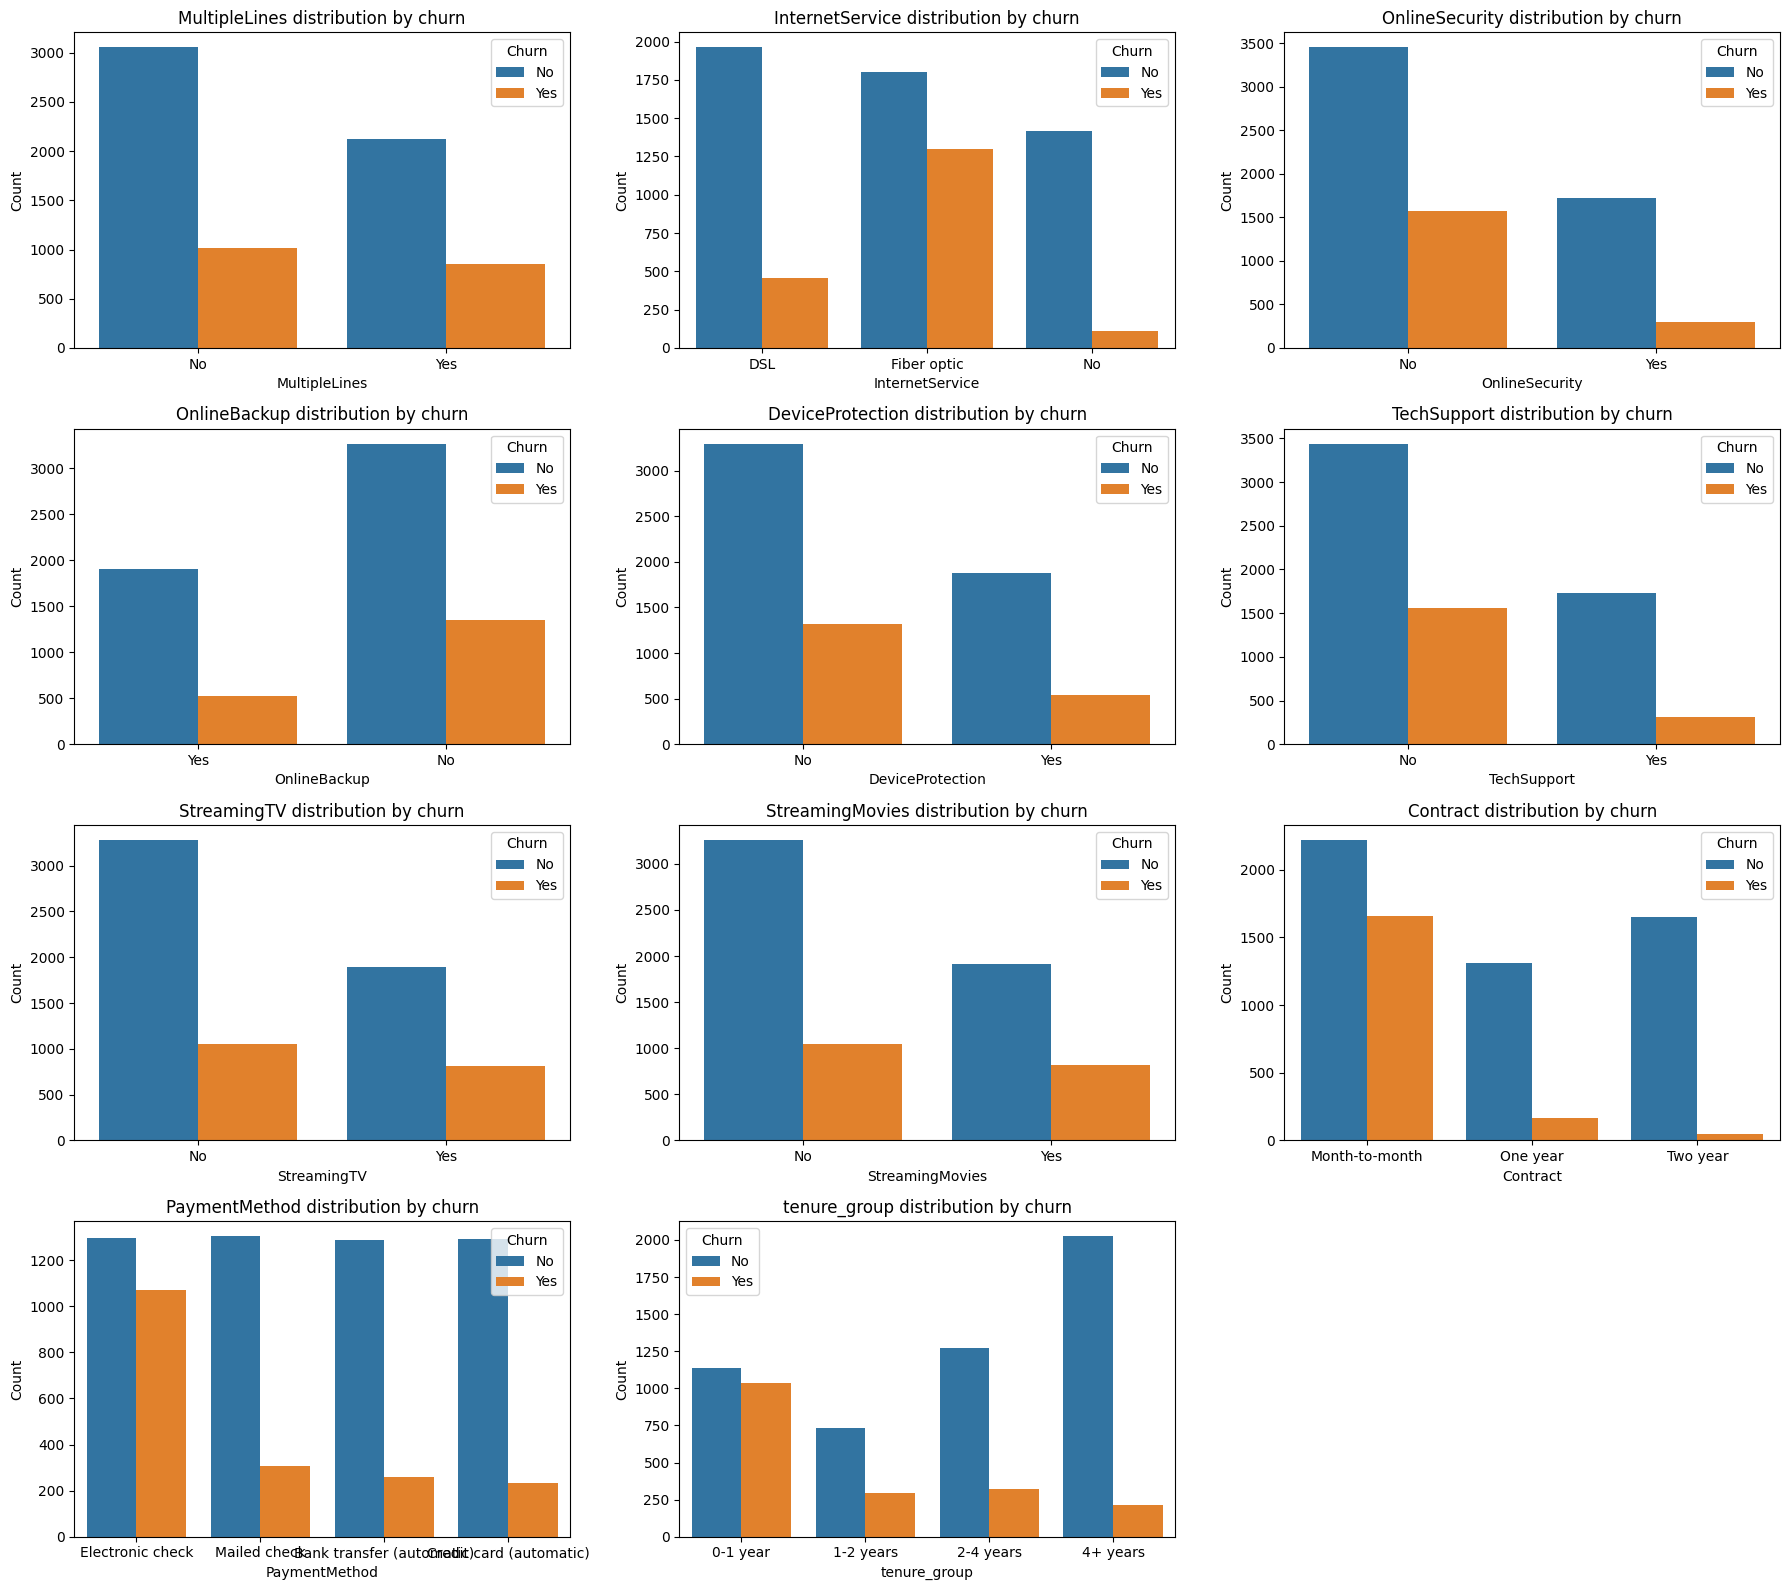

In [18]:
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, hue='Churn', ax=axes[i])
    axes[i].set_title(f'{col} distribution by churn')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Churn', labels=['No', 'Yes'])

for j in range(len(categorical_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Dropping unnecessary columns including customerID and binary features already created**

In [19]:
df_ml = df.drop(columns=['customerID'] + [col for col in df.columns if col.endswith('_binary')])

In [20]:
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

In [21]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_charges', 'total_services']

**Boxplot analysis for numeric columns**

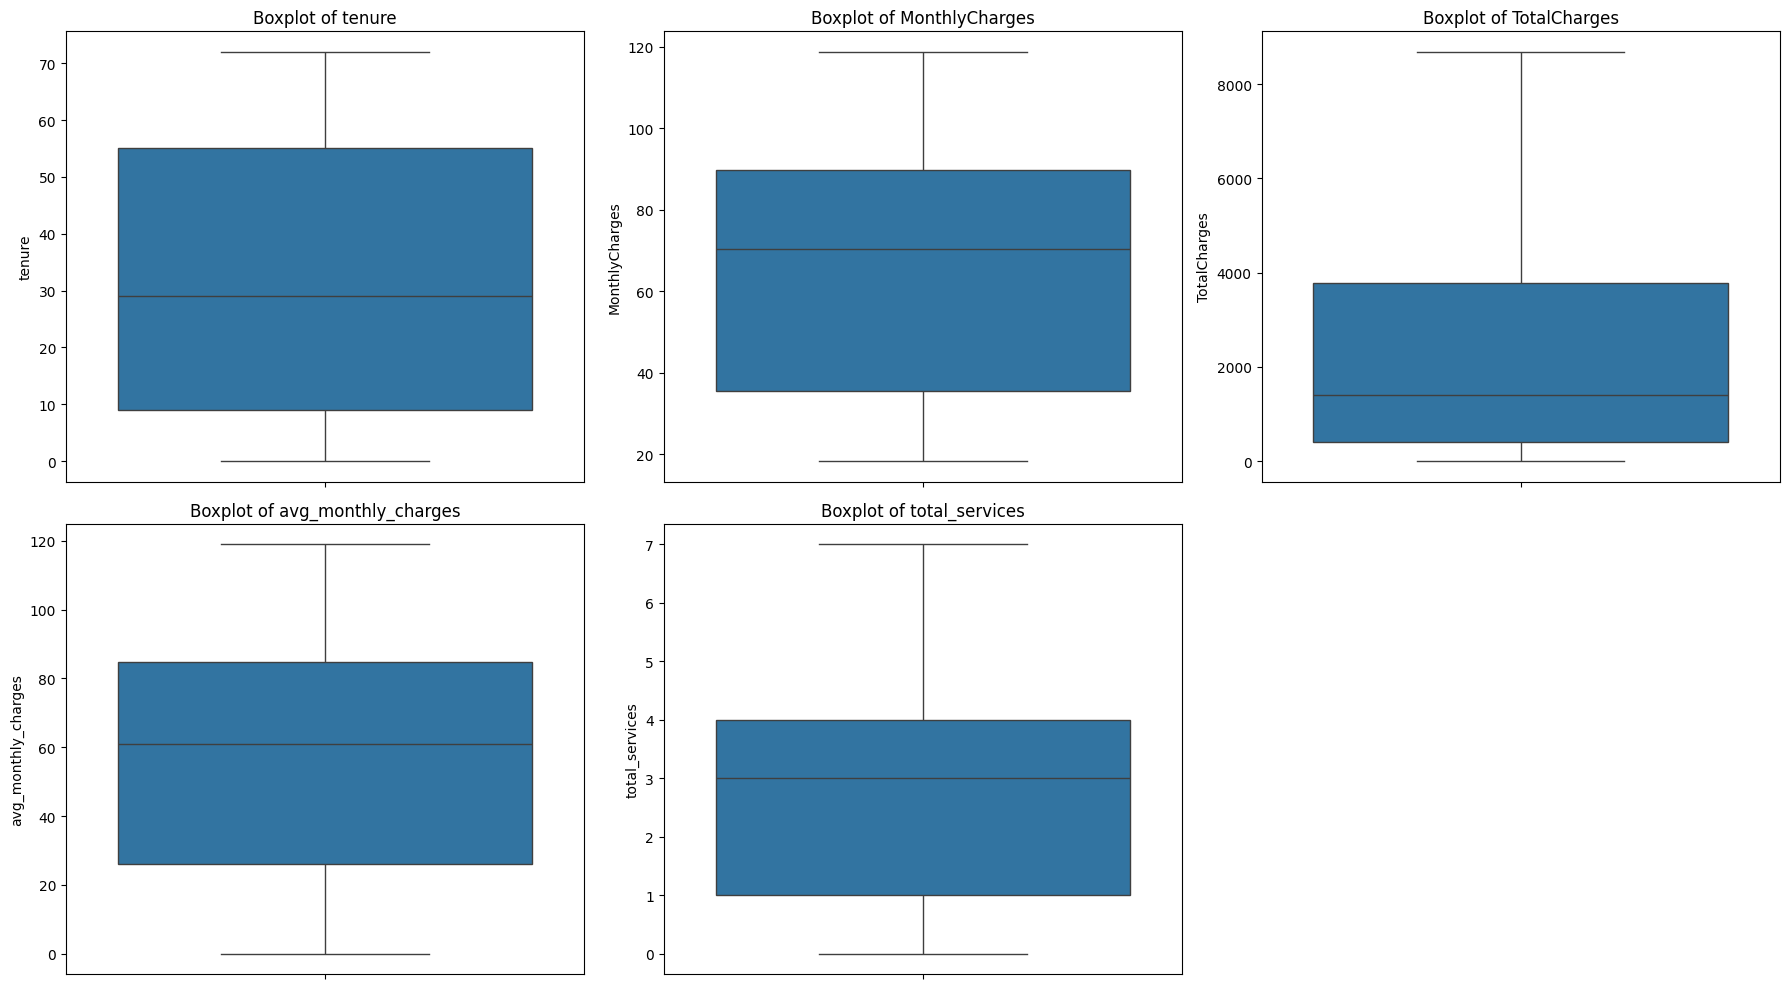

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Distribution (KDE) plots of numeric columns split by churn**

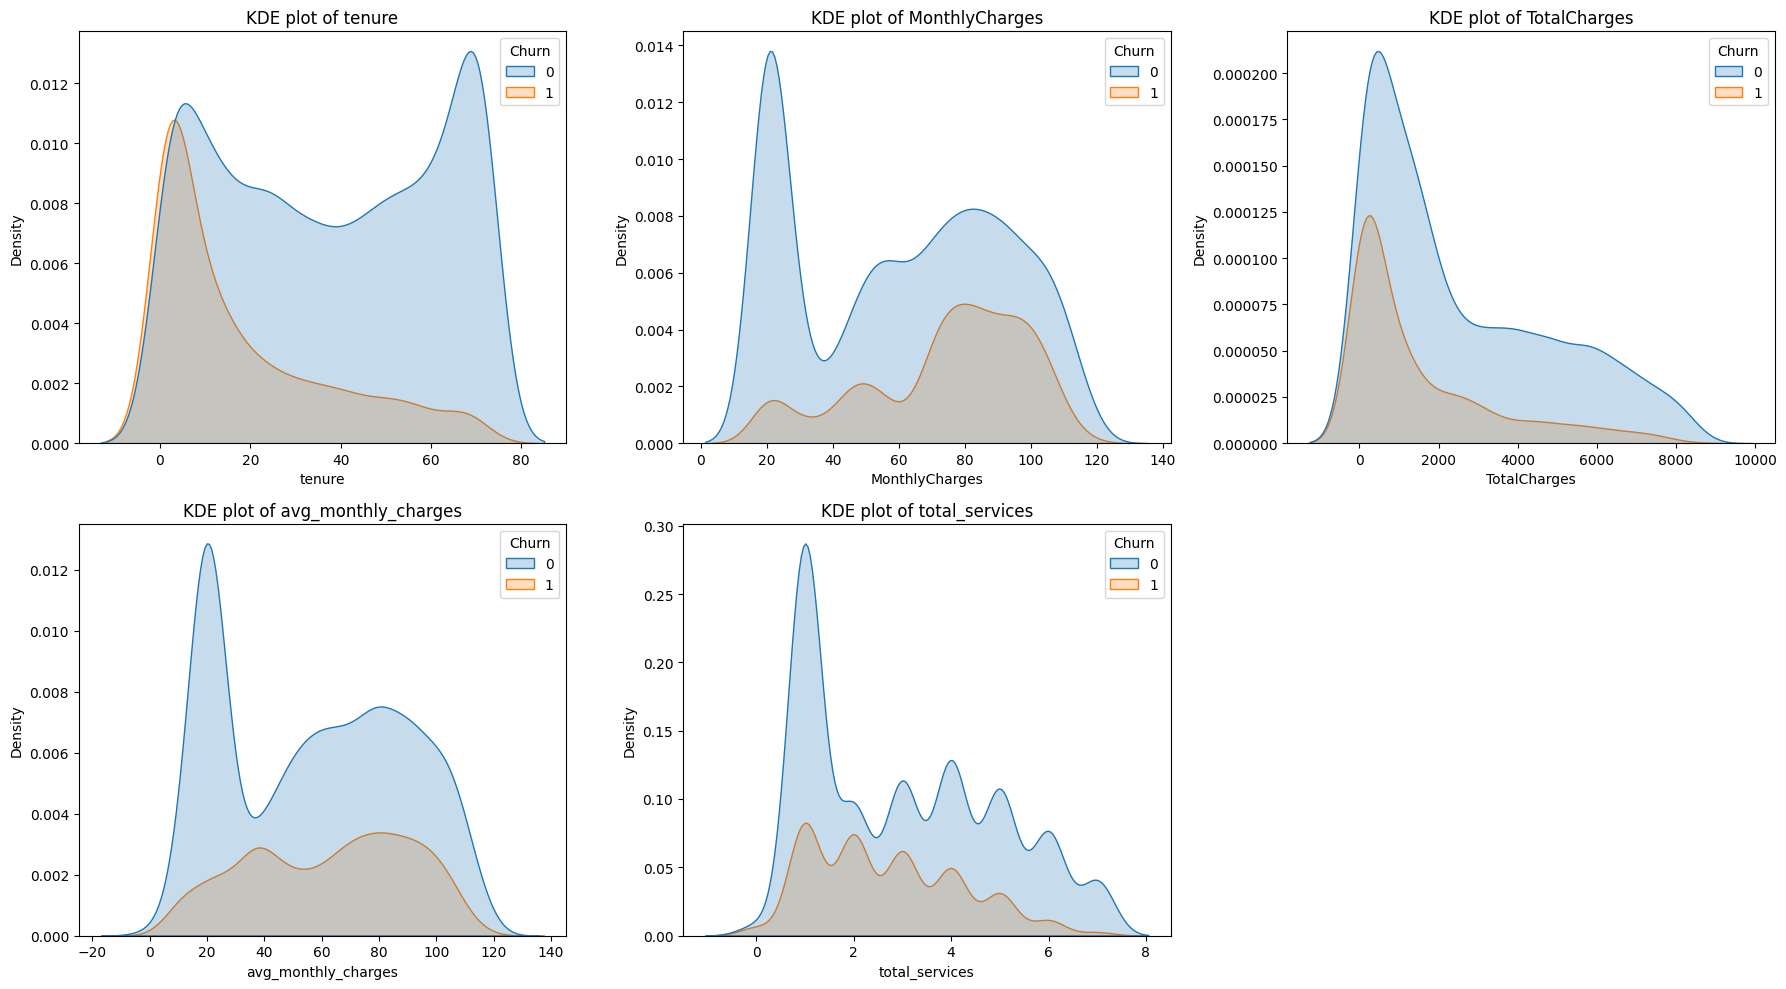

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=df, x=col, hue='Churn', ax=axes[i], fill=True)
    axes[i].set_title(f'KDE plot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

for j in range(len(numeric_cols), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Encoding categorical features with OneHotEncoding for ML model**

In [24]:
onehot = OneHotEncoder(drop='first', sparse_output=False)
X_cat = X[categorical_cols]
X_cat_enc = pd.DataFrame(
    onehot.fit_transform(X_cat),
    columns=onehot.get_feature_names_out(categorical_cols),
    index=X.index
).astype(int)

In [25]:
X_other = X.drop(columns=categorical_cols)
X_final = pd.concat([X_other, X_cat_enc], axis=1)

In [26]:
X_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,avg_monthly_charges,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-2 years,tenure_group_2-4 years,tenure_group_4+ years,tenure_group_nan
0,0,0,1,0,1,0,1,29.85,29.85,14.925000,...,0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,34,1,0,56.95,1889.50,53.985714,...,0,1,0,0,0,1,0,1,0,0
2,1,0,0,0,2,1,1,53.85,108.15,36.050000,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,45,0,0,42.30,1840.75,40.016304,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,2,1,1,70.70,151.65,50.550000,...,0,0,0,0,1,0,0,0,0,0


In [27]:
print("After encoding, feature matrix shape: ", X_final.shape)

After encoding, feature matrix shape:  (7043, 33)


**Correlation matric for (non-categorical, non-encoded) features**

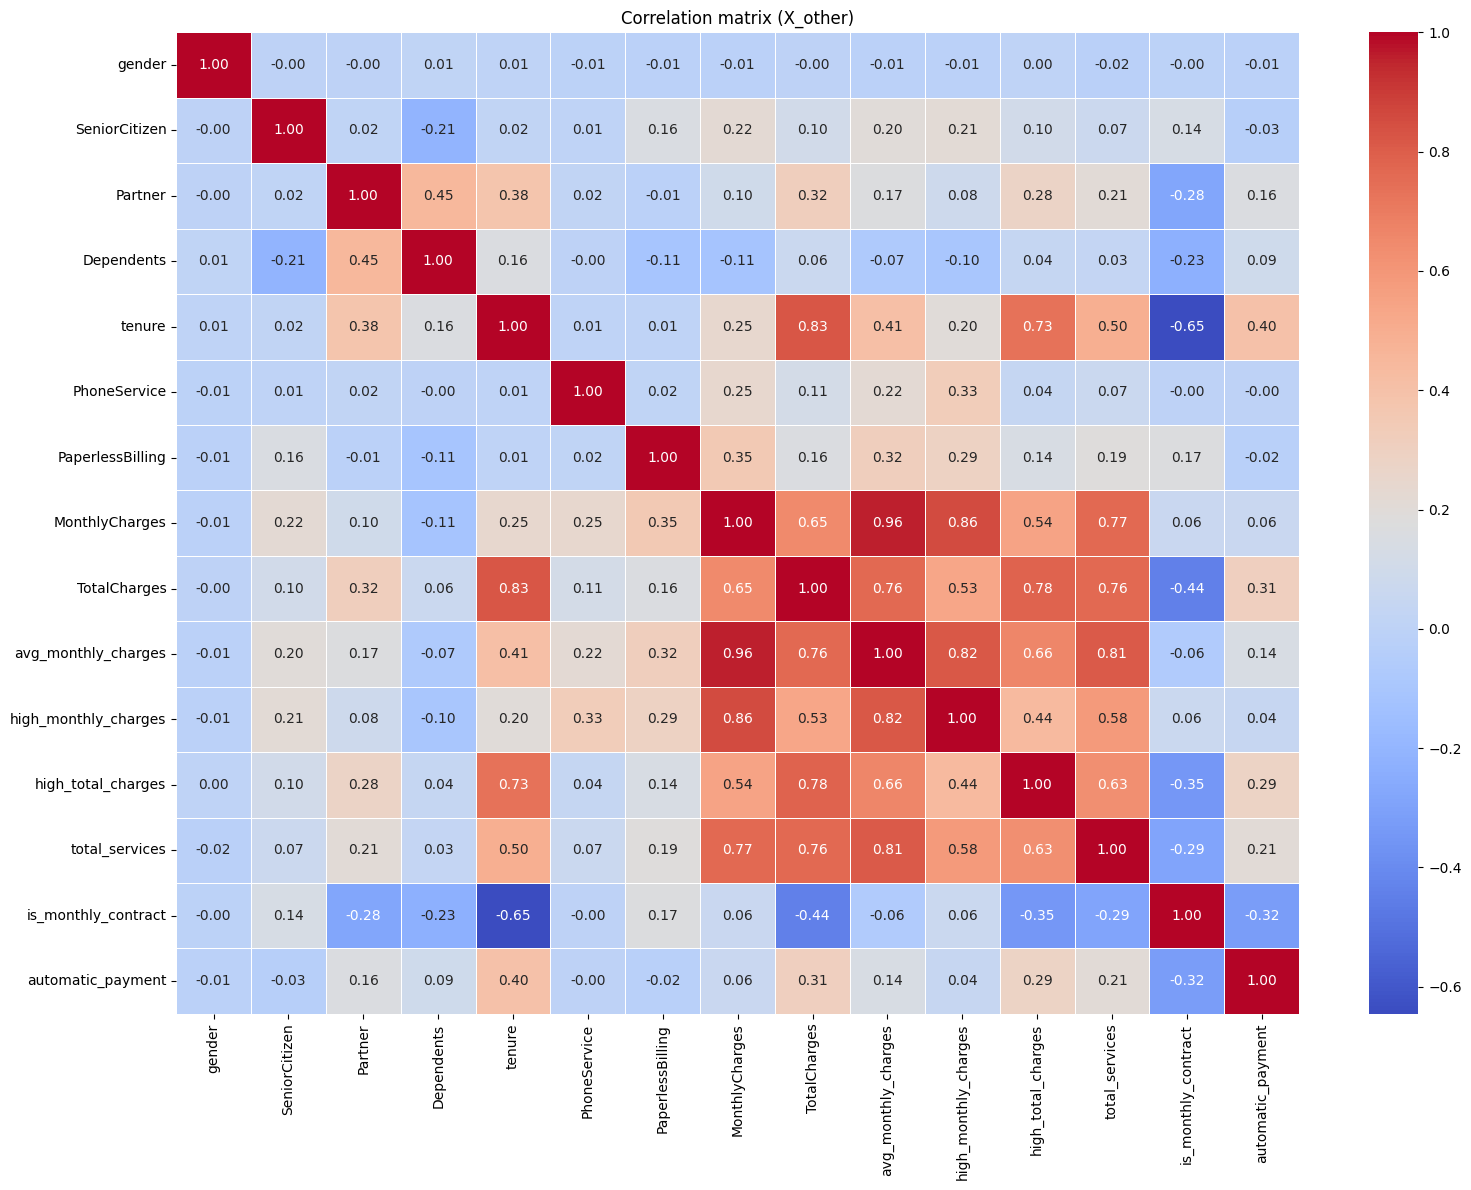

In [28]:
corr_matrix = X_other.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation matrix (X_other)")
plt.tight_layout()
plt.show()

**Train-test split and feature scaling**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, stratify=y, random_state=42)

In [30]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.fit_transform(X_test[numeric_cols])

**Defining ML models for comparison**

In [31]:
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

**Training and evaluating models with various metrics**

In [32]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name in ['Logistic Regression', 'SVM']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1, "AUC-ROC": auc,
                     "CV Mean": cv_scores.mean(), "CV Std": cv_scores.std()}

    for name, metrics in results.items():
        print(f"Results for {name}:")
        print(f"  Accuracy: {metrics['Accuracy']:.3f}")
        print(f"  Precision: {metrics['Precision']:.3f}")
        print(f"  Recall: {metrics['Recall']:.3f}")
        print(f"  F1-Score: {metrics['F1-Score']:.3f}")
        print(f"  AUC-ROC: {metrics['AUC-ROC']:.3f}")
        print(f"  CV Mean: {metrics['CV Mean']:.3f}")
        print(f"  CV Std: {metrics['CV Std']:.3f}\n")


Training k-Nearest Neighbors...
Results for k-Nearest Neighbors:
  Accuracy: 0.788
  Precision: 0.688
  Recall: 0.366
  F1-Score: 0.478
  AUC-ROC: 0.784
  CV Mean: 0.781
  CV Std: 0.013

Training Logistic Regression...
Results for k-Nearest Neighbors:
  Accuracy: 0.788
  Precision: 0.688
  Recall: 0.366
  F1-Score: 0.478
  AUC-ROC: 0.784
  CV Mean: 0.781
  CV Std: 0.013

Results for Logistic Regression:
  Accuracy: 0.804
  Precision: 0.670
  Recall: 0.516
  F1-Score: 0.583
  AUC-ROC: 0.846
  CV Mean: 0.807
  CV Std: 0.010

Training Random Forest...
Results for k-Nearest Neighbors:
  Accuracy: 0.788
  Precision: 0.688
  Recall: 0.366
  F1-Score: 0.478
  AUC-ROC: 0.784
  CV Mean: 0.781
  CV Std: 0.013

Results for Logistic Regression:
  Accuracy: 0.804
  Precision: 0.670
  Recall: 0.516
  F1-Score: 0.583
  AUC-ROC: 0.846
  CV Mean: 0.807
  CV Std: 0.010

Results for Random Forest:
  Accuracy: 0.781
  Precision: 0.609
  Recall: 0.487
  F1-Score: 0.541
  AUC-ROC: 0.822
  CV Mean: 0.788
  C

**ROC curves**

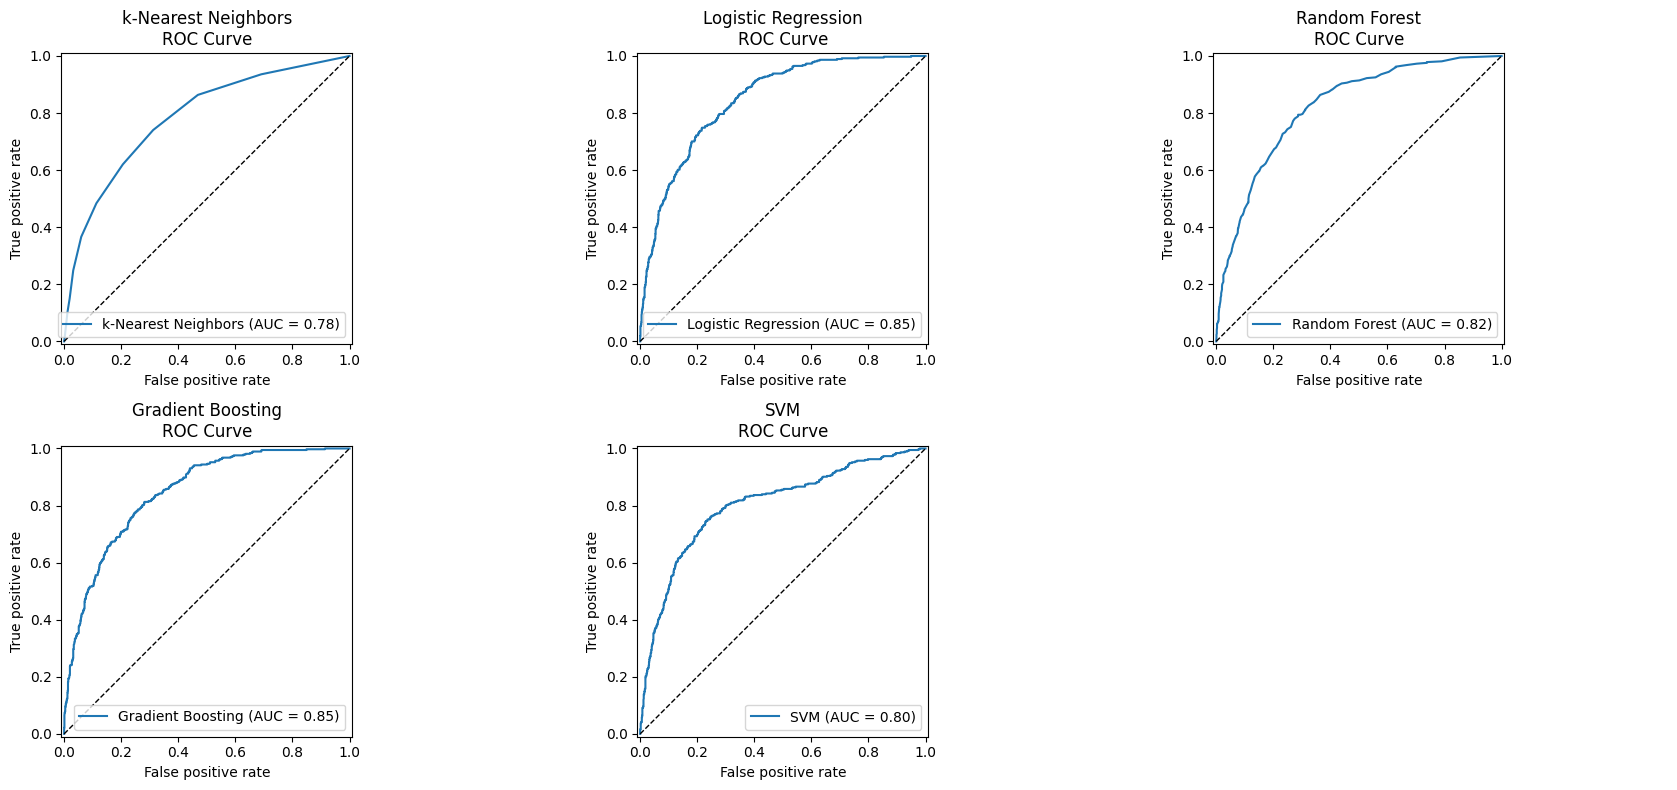

In [46]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):
    if model_name in ['Logistic Regression', 'SVM']:
        RocCurveDisplay.from_estimator(model, X_test_scaled, y_test, ax=axes[i], name=model_name)
    else:
        RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[i], name=model_name)
    axes[i].set_title(f"{model_name}\nROC Curve")
    axes[i].set_xlabel("False positive rate")
    axes[i].set_ylabel("True positive rate")
    axes[i].plot([0, 1], [0, 1], color='black', linestyle='--', linewidth=1)

for j in range(len(models), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Confusion matrixes**

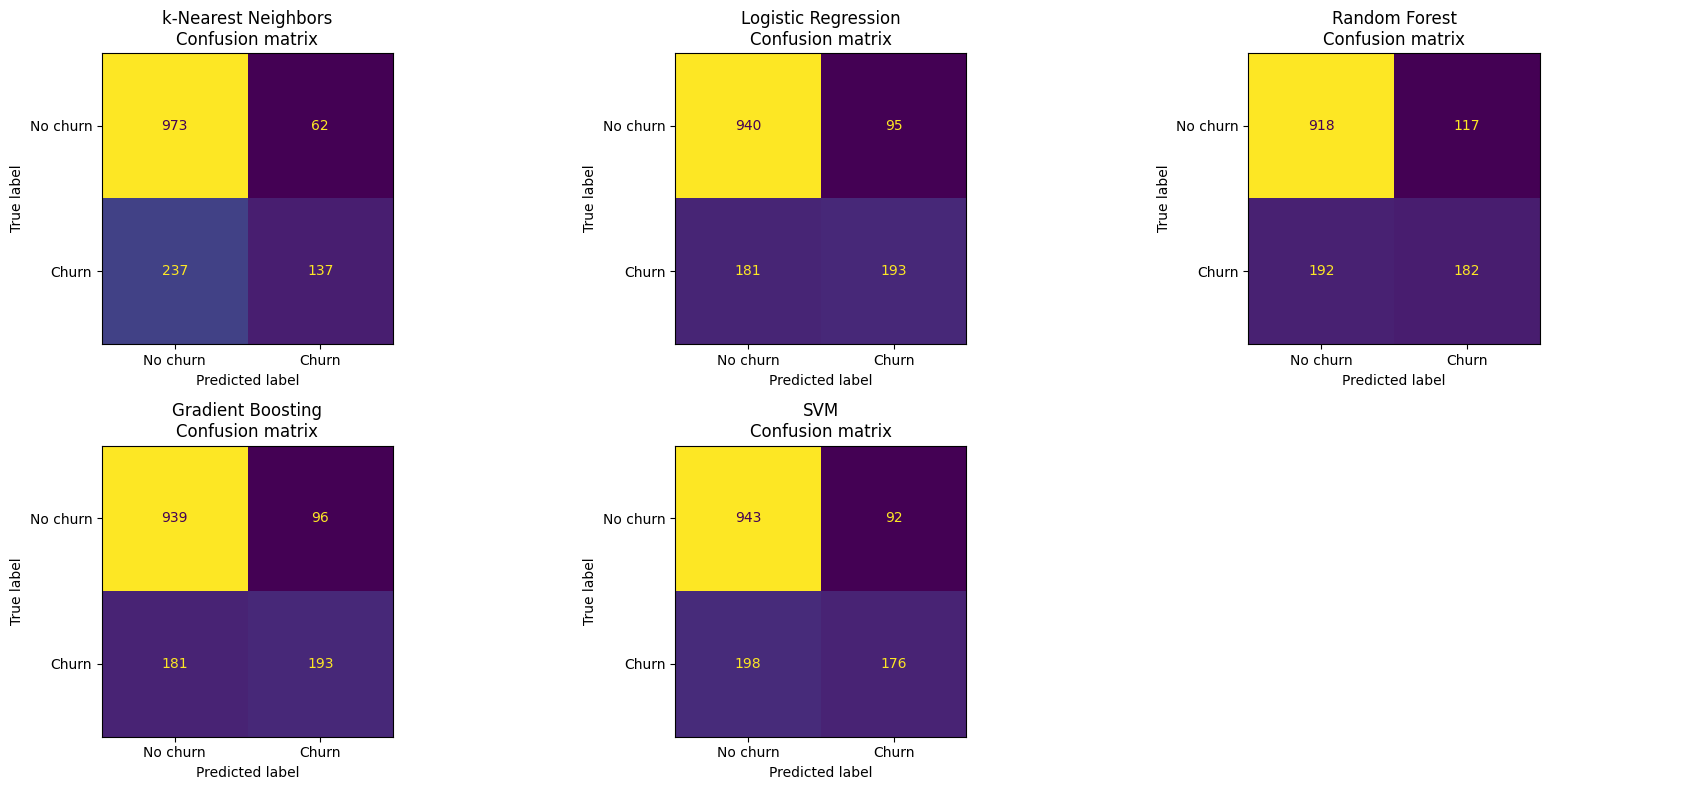

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for i, (model_name, model) in enumerate(models.items()):
    if model_name in ['Logistic Regression', 'SVM']:
        y_pred_model = model.predict(X_test_scaled)
    else:
        y_pred_model = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_model)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No churn', 'Churn'])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f"{model_name}\nConfusion matrix")
    axes[i].set_xlabel("Predicted label")
    axes[i].set_ylabel("True label")

for j in range(len(models), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Hyperparametric tuning: Logistic Regression grid search**

In [35]:
print("\nHyperparameter tuning for Logistic Regression...")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print(f"Best CV AUC: {grid_search.best_score_:.3f}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

print("\nOptimized Logistic Regression performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1-Score:", f1_score(y_test, y_pred_best))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_best))


Hyperparameter tuning for Logistic Regression...
Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV AUC: 0.849

Optimized Logistic Regression performance:
Accuracy: 0.8034066713981547
Precision: 0.6655290102389079
Recall: 0.5213903743315508
F1-Score: 0.5847076461769115
AUC-ROC: 0.8456224650598053


**Feature importance analysis for Logistic Regression**

In [36]:
coef_abs = np.abs(best_model.coef_[0])
feat_importance = pd.DataFrame({'Feature': X_final.columns, 'Importance': coef_abs}).sort_values(by='Importance', ascending=False)
print("Top 15 important features:\n", feat_importance.head(15))

Top 15 important features:
                         Feature  Importance
16  InternetService_Fiber optic    2.352817
32             tenure_group_nan    2.237870
17           InternetService_No    2.161940
25            Contract_Two year    1.293583
12               total_services    1.232792
9           avg_monthly_charges    0.967113
4                        tenure    0.960320
7                MonthlyCharges    0.959308
18           OnlineSecurity_Yes    0.737673
15            MultipleLines_Yes    0.683152
21              TechSupport_Yes    0.679871
14            automatic_payment    0.597248
28   PaymentMethod_Mailed check    0.569302
19             OnlineBackup_Yes    0.526015
24            Contract_One year    0.439840


**Additional business analysis: churn by contract and financial impact**

In [37]:
contract_churn = df.groupby('Contract')['Churn'].agg(['count', 'sum', 'mean']).round(3)
contract_churn.columns = ['Total_Customers', 'Churned_Customers', 'Churn_Rate']

print("Churn by contract type:\n", contract_churn)

avg_monthly_churn = df[df['Churn']==1]['MonthlyCharges'].mean()
avg_monthly_retain = df[df['Churn']==0]['MonthlyCharges'].mean()
total_revenue_lost = df[df['Churn']==1]['TotalCharges'].mean()

print(f"\nFinancial Impact:\nAvg monthly charges - churned: ${avg_monthly_churn:.2f}")
print(f"Avg monthly charges - retained: ${avg_monthly_retain:.2f}")
print(f"Total revenue lost: ${total_revenue_lost:,.2f}")

Churn by contract type:
                 Total_Customers  Churned_Customers  Churn_Rate
Contract                                                      
Month-to-month             3875               1655       0.427
One year                   1473                166       0.113
Two year                   1695                 48       0.028

Financial Impact:
Avg monthly charges - churned: $74.44
Avg monthly charges - retained: $61.27
Total revenue lost: $1,531.80


**Churn risk probability and targeting strategy**

In [47]:
risk_scores = best_model.predict_proba(X_test_scaled)[:, 1]
risk_categories = pd.cut(risk_scores, bins=[0, 0.3, 0.7, 1.0], labels=['Low Risk', 'Medium Risk', 'High Risk'])
prediction_results = pd.DataFrame({'Churn_Probability': risk_scores, 'Risk_Category': risk_categories, 'Actual_Churn': y_test.values})

print("Risk category distribution:\n", prediction_results['Risk_Category'].value_counts())

high_risk_targets = prediction_results[(prediction_results['Risk_Category']=='High Risk') & (prediction_results['Actual_Churn']==0)].shape[0]
print(f"\nHigh-risk customers to target for retention: {high_risk_targets}")


Risk category distribution:
 Risk_Category
Low Risk       880
Medium Risk    424
High Risk      105
Name: count, dtype: int64

High-risk customers to target for retention: 21


**Visualizations: contract-specific churn, model comparison, and feature importance**

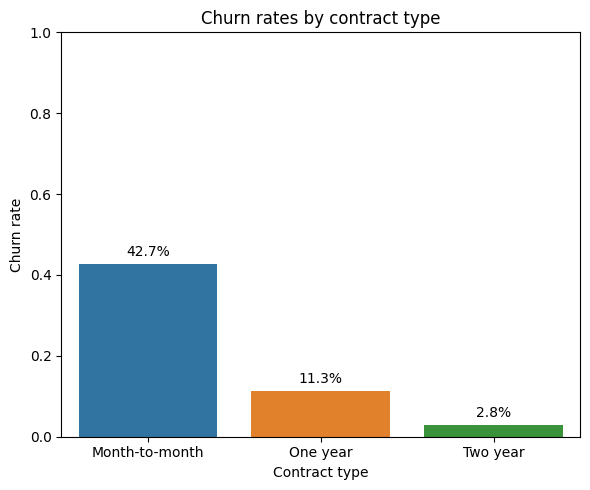

In [39]:
contract_rates = df.groupby('Contract')['Churn'].mean()
plt.figure(figsize=(6,5))
sns.barplot(x=contract_rates.index, y=contract_rates.values, hue=contract_rates.index)
plt.title('Churn rates by contract type')
plt.ylabel('Churn rate')
plt.xlabel('Contract type')
plt.ylim(0,1)
for i, rate in enumerate(contract_rates.values):
    plt.text(i, rate + 0.02, f"{rate:.1%}", ha='center')
plt.tight_layout()

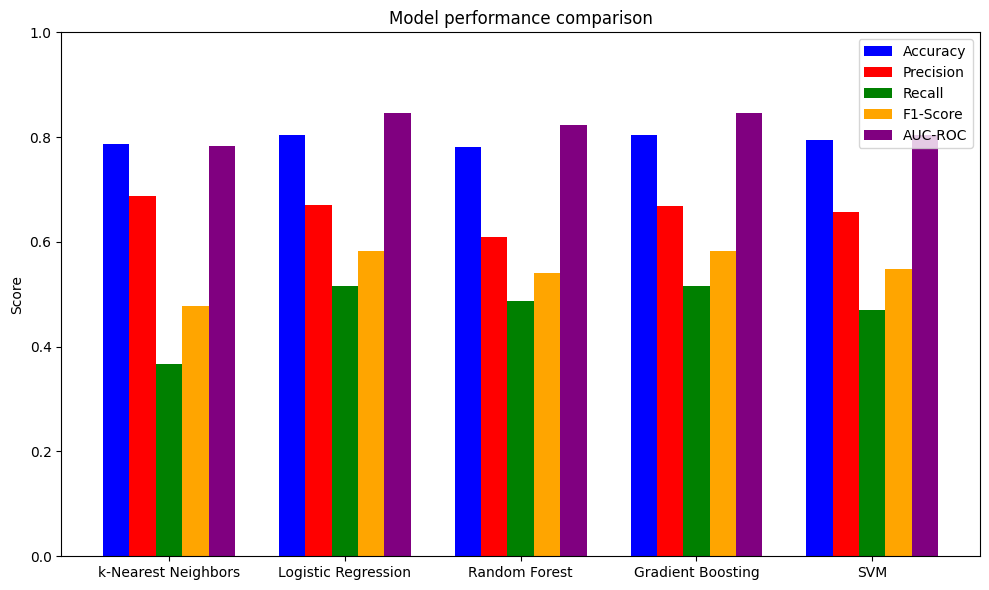

In [40]:
model_names = list(results.keys())
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors = ['blue', 'red', 'green', 'orange', 'purple']

x = np.arange(len(model_names))
width = 0.15

plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics):
    metric_values = [results[m][metric] for m in model_names]
    plt.bar(x + i*width, metric_values, width=width, label=metric, color=colors[i])
plt.xticks(x + 2*width, model_names)
plt.ylim(0,1)
plt.title('Model performance comparison')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()

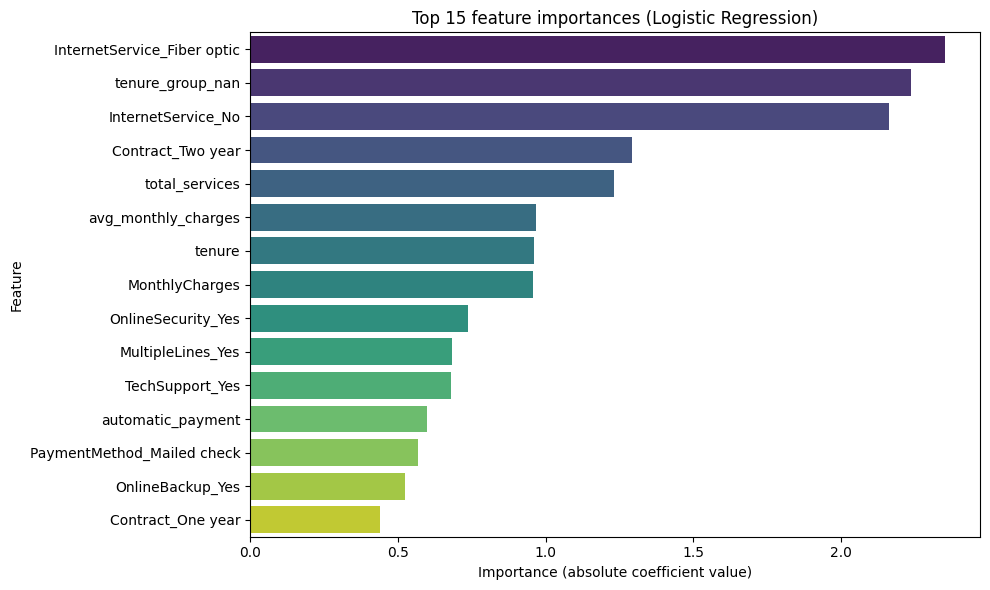

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_importance.head(15),
    hue='Feature',
    palette='viridis',
    legend=False
)
plt.title('Top 15 feature importances (Logistic Regression)')
plt.xlabel('Importance (absolute coefficient value)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**SHAP values: model explainability for risk prediction**

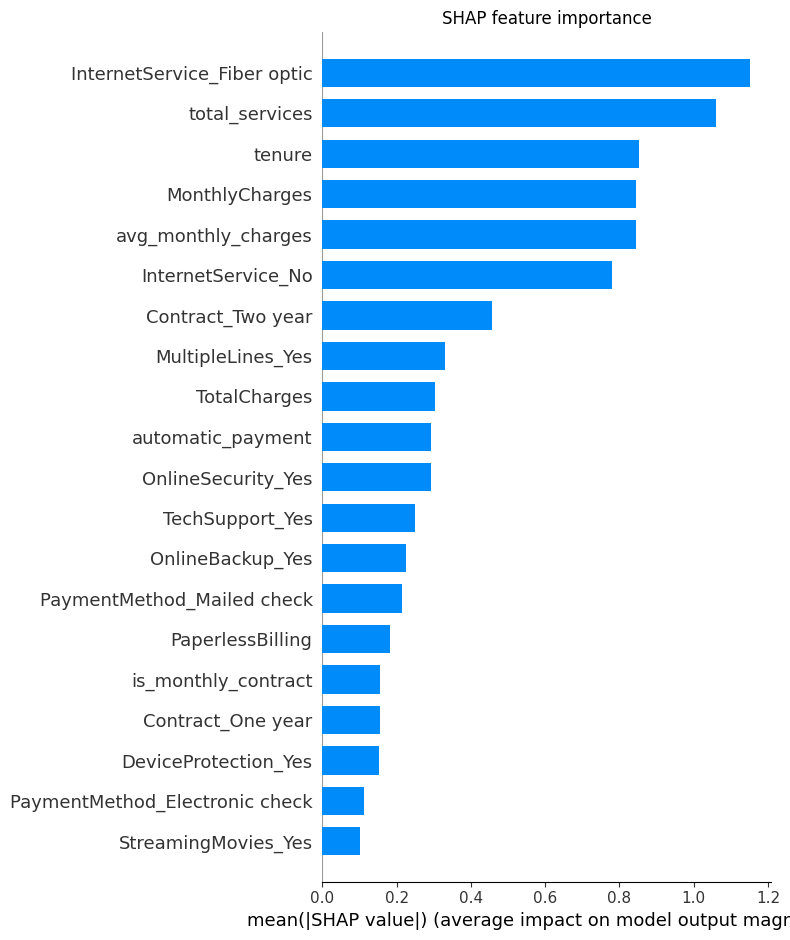

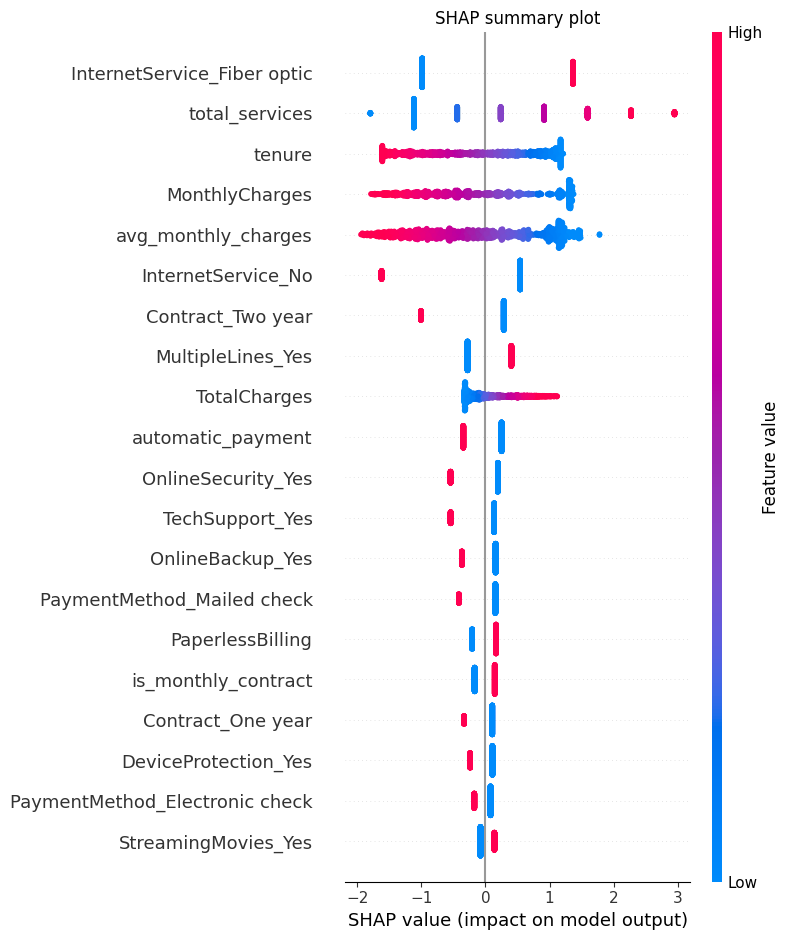

In [42]:
explainer = shap.Explainer(best_model, X_test_scaled)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", show=False)
plt.title("SHAP feature importance")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title("SHAP summary plot")
plt.tight_layout()
plt.show()

**Feature selection: reducing numer of features using L1 regularization**

In [43]:
selector = SelectFromModel(
    LogisticRegression(penalty='l1', C=best_model.C, solver='liblinear', max_iter=1000, random_state=42)
)
selector.fit(X_train_scaled, y_train)

selected_features = X_train_scaled.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())

X_train_selected = X_train_scaled[selected_features]
X_test_selected = X_test_scaled[selected_features]

model_fs = LogisticRegression(C=best_model.C, solver='liblinear', max_iter=1000, random_state=42)
model_fs.fit(X_train_selected, y_train)
y_pred_fs = model_fs.predict(X_test_selected)
y_pred_proba_fs = model_fs.predict_proba(X_test_selected)[:, 1]

print("\nPerformance with selected features:")
print("Accuracy:", accuracy_score(y_test, y_pred_fs))
print("Precision:", precision_score(y_test, y_pred_fs))
print("Recall:", recall_score(y_test, y_pred_fs))
print("F1-Score:", f1_score(y_test, y_pred_fs))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_fs))

Selected features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_charges', 'high_monthly_charges', 'high_total_charges', 'total_services', 'automatic_payment', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check', 'tenure_group_1-2 years', 'tenure_group_2-4 years', 'tenure_group_4+ years', 'tenure_group_nan']

Performance with selected features:
Accuracy: 0.8034066713981547
Precision: 0.6655290102389079
Recall: 0.5213903743315508
F1-Score: 0.5847076461769115
AUC-ROC: 0.84562763181689


**Sensivity analysis for numeric features: effect on churn probability**

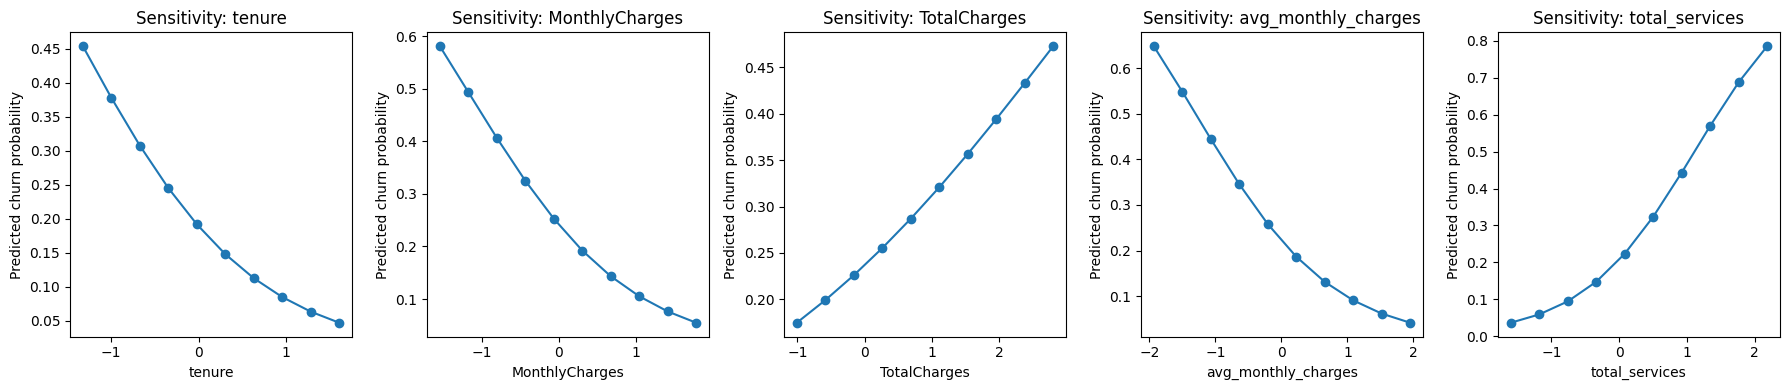

In [44]:
numeric_sensitivity_results = {}

for feature in numeric_cols:
    feature_min = X_train_selected[feature].min()
    feature_max = X_train_selected[feature].max()
    feature_values = np.linspace(feature_min, feature_max, 10)
    median_sample = X_train_selected.median().to_frame().T

    probs = []
    for val in feature_values:
        sample = median_sample.copy()
        sample[feature] = val
        prob = model_fs.predict_proba(sample)[:, 1][0]
        probs.append(prob)
    numeric_sensitivity_results[feature] = (feature_values, probs)

plt.figure(figsize=(18, 4))
for i, feature in enumerate(numeric_cols):
    plt.subplot(1, len(numeric_cols), i+1)
    vals, probs = numeric_sensitivity_results[feature]
    plt.plot(vals, probs, marker='o')
    plt.title(f"Sensitivity: {feature}")
    plt.xlabel(feature)
    plt.ylabel("Predicted churn probability")
plt.tight_layout()
plt.show()
